In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import time
import os
import PIL.Image as Image
from IPython.display import display

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
Tesla V100-SXM2-16GB


In [2]:
dataset_dir = "./car_data/"

train_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(15),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.ImageFolder(root=dataset_dir+"train", transform = train_tfms)
trainloader = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle=True, num_workers = 2)

dataset2 = torchvision.datasets.ImageFolder(root=dataset_dir+"test", transform = test_tfms)
testloader = torch.utils.data.DataLoader(dataset2, batch_size = 32, shuffle=False, num_workers = 2)

In [3]:
def train_model(model, criterion, optimizer, scheduler, n_epochs = 5):
    
    losses = []
    accuracies = []
    test_accuracies = []
    # set the model to train mode initially
    model.train()
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(trainloader, 0):

            # get the inputs and assign them to cuda
            inputs, labels = data
            #inputs = inputs.to(device).half() # uncomment for half precision model
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # calculate the loss/acc later
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(trainloader)
        epoch_acc = 100/32*running_correct/len(trainloader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)
        
        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies


In [4]:
def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data
            #images = images.to(device).half() # uncomment for half precision model
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model_ft(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (
        test_acc))
    return test_acc

In [5]:
model_ft = models.resnet34(pretrained=False)
num_ftrs = model_ft.fc.in_features

# replace the last fc layer with an untrained one (requires grad by default)
model_ft.fc = nn.Linear(num_ftrs, 196)
model_ft = model_ft.to(device)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

In [ ]:
model_ft, training_losses, training_accs, test_accs = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=10)

Epoch 1, duration: 167 s, loss: 5.3593, acc: 0.6495
Accuracy of the network on the test images: 0 %
Epoch 2, duration: 99 s, loss: 5.2159, acc: 1.2255
Accuracy of the network on the test images: 1 %
Epoch 3, duration: 99 s, loss: 5.1561, acc: 1.6299
Accuracy of the network on the test images: 1 %
Epoch 4, duration: 101 s, loss: 5.1058, acc: 1.6054
Accuracy of the network on the test images: 1 %
Epoch 5, duration: 98 s, loss: 5.0362, acc: 1.9853
Accuracy of the network on the test images: 1 %
Epoch 6, duration: 99 s, loss: 4.9580, acc: 2.8676


Text(0.5, 1.0, 'Test acc')

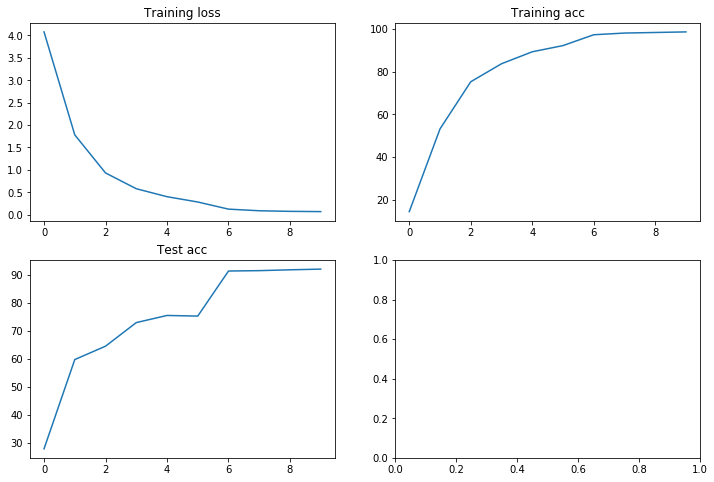

In [8]:
# plot the stats

f, axarr = plt.subplots(2,2, figsize = (12, 8))
axarr[0, 0].plot(training_losses)
axarr[0, 0].set_title("Training loss")
axarr[0, 1].plot(training_accs)
axarr[0, 1].set_title("Training acc")
axarr[1, 0].plot(test_accs)

axarr[1, 0].set_title("Test acc")

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)
model_ft, training_losses, training_accs, test_accs = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=5)

Epoch 1, duration: 82 s, loss: 0.0619, acc: 98.8235
Accuracy of the network on the test images: 92 %
Epoch 2, duration: 83 s, loss: 0.0569, acc: 98.9093
Accuracy of the network on the test images: 92 %
Epoch 3, duration: 82 s, loss: 0.0536, acc: 98.9338
Accuracy of the network on the test images: 92 %
Epoch 4, duration: 82 s, loss: 0.0499, acc: 99.0809
Accuracy of the network on the test images: 92 %
Epoch 5, duration: 82 s, loss: 0.0465, acc: 99.0931
Accuracy of the network on the test images: 92 %
Finished Training


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)
model_ft, training_losses, training_accs, test_accs = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=5)

Epoch 1, duration: 83 s, loss: 0.0257, acc: 99.5221
Accuracy of the network on the test images: 90 %
Epoch 2, duration: 84 s, loss: 0.0257, acc: 99.4118
Accuracy of the network on the test images: 90 %
Epoch 3, duration: 83 s, loss: 0.0242, acc: 99.4853
Accuracy of the network on the test images: 90 %
Epoch 4, duration: 84 s, loss: 0.0241, acc: 99.4853
Accuracy of the network on the test images: 90 %
Epoch 5, duration: 85 s, loss: 0.0258, acc: 99.5098
